# New York Metro Area AQI Analysis during Covid 19

# Objective

#### An analysis of air quality changes in four metropolitan areas during the initial Covid 19 onset.  Metro areas of analysis include the greater San Francisco, CA; New York City, NY; Los Angeles, CA; and Salt Lake City, UT areas.  Analysis explores the location and trends of daily AQI during the respective Covid lockdown periods compared to the AQI during the same months in years prior.

#### Covid-19 Restriction Start Dates
 - San Francisco: **March 17, 2020**
 - Los Angeles: 
 - New York-Newark-Jersey City: 
 - Salt Lake City: 

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx
from shapely.geometry import Point, Polygon

import pandas_profiling as pp

In [2]:
# US daily AQI data from 1980-01-01 to 2021-05-18
cbsa_aqi = pd.read_csv('data_raw/cbsa_sites_df.csv', usecols = ['CBSA',
                                                                'CBSA Code',
                                                                'Date',
                                                                'AQI',
                                                                'Category',
                                                                'Defining Parameter',
                                                                'Defining Site'])

monitors = pd.read_csv('data_raw/monitors_CA_NY_UT.csv', usecols = ['Defining Site',
                                                                    'Latitude',
                                                                    'Longitude',
                                                                    'Monitor Type']) # pre-filtered to four sites

In [3]:
print(cbsa_aqi.shape)
print(monitors.shape)

(61550, 7)
(55083, 4)


In [4]:
cbsa_aqi.head(2)

,CBSA,CBSA Code,Date,AQI,Category,Defining Parameter,Defining Site
0,"New York-Newark-Jersey City, NY-NJ-PA",35620,2021-01-01,56,Moderate,PM2.5,36-071-0002
1,"New York-Newark-Jersey City, NY-NJ-PA",35620,2021-01-02,39,Good,PM2.5,36-061-0135


In [5]:
# data types of columns
print(monitors.dtypes)
print("")
print(cbsa_aqi.dtypes)

Latitude         float64
Longitude        float64
Monitor Type      object
Defining Site     object
dtype: object

CBSA                  object
CBSA Code              int64
Date                  object
AQI                    int64
Category              object
Defining Parameter    object
Defining Site         object
dtype: object


### Merge dataframes

In [26]:
cbsa = cbsa_aqi.merge(monitors, on='Defining Site', how='left').drop_duplicates(ignore_index=True)

In [27]:
cbsa.shape

(159605, 10)

In [28]:
cbsa.head(2)

,CBSA,CBSA Code,Date,AQI,Category,Defining Parameter,Defining Site,Latitude,Longitude,Monitor Type
0,"New York-Newark-Jersey City, NY-NJ-PA",35620,2021-01-01,56,Moderate,PM2.5,36-071-0002,41.49916,-74.00885,SLAMS
1,"New York-Newark-Jersey City, NY-NJ-PA",35620,2021-01-02,39,Good,PM2.5,36-061-0135,40.81976,-73.94825,SLAMS


In [29]:
cbsa.shape

(159605, 10)

### Format data

In [30]:
# format date as datetime
cbsa['Date']=pd.to_datetime(cbsa['Date'], format = '%Y-%m-%d')

# convert Category column to category data type
cbsa['Category']=cbsa.Category.astype('category') 

In [31]:
cbsa['CBSA'].unique()

array(['New York-Newark-Jersey City, NY-NJ-PA', 'Salt Lake City, UT',
       'Los Angeles-Long Beach-Anaheim, CA',
       'San Francisco-Oakland-Hayward, CA'], dtype=object)

In [32]:
cbsa.dtypes

CBSA                          object
CBSA Code                      int64
Date                  datetime64[ns]
AQI                            int64
Category                    category
Defining Parameter            object
Defining Site                 object
Latitude                     float64
Longitude                    float64
Monitor Type                  object
dtype: object

## Create new columns year and month_day

In [33]:
#cbsa['year'] = cbsa['Date'].dt.year
#cbsa['month_day'] = cbsa['Date'].dt.strftime('%m-%d')

### Reorder columns

In [34]:
cbsa_df = cbsa[['Date','AQI','Defining Parameter','Category','CBSA','Longitude','Latitude']]

In [35]:
cbsa_df.head()

,Date,AQI,Defining Parameter,Category,CBSA,Longitude,Latitude
0,2021-01-01,56,PM2.5,Moderate,"New York-Newark-Jersey City, NY-NJ-PA",-74.008850,41.499160
1,2021-01-02,39,PM2.5,Good,"New York-Newark-Jersey City, NY-NJ-PA",-73.948250,40.819760
2,2021-01-03,42,PM2.5,Good,"New York-Newark-Jersey City, NY-NJ-PA",-73.817694,40.739264
3,2021-01-04,44,PM2.5,Good,"New York-Newark-Jersey City, NY-NJ-PA",-74.008850,41.499160
4,2021-01-05,40,PM2.5,Good,"New York-Newark-Jersey City, NY-NJ-PA",-73.817694,40.739264


## Set Index as Date column

In [36]:
cbsa_df.set_index('Date', inplace=True)

#### Calculate Rolling Mean

In [79]:
cbsa_rolling = cbsa_df.copy()

window = 60

cbsa_rolling['rolling_AQI_mean'] = cbsa_rolling['AQI'].rolling(window = window).mean()

# Plot data

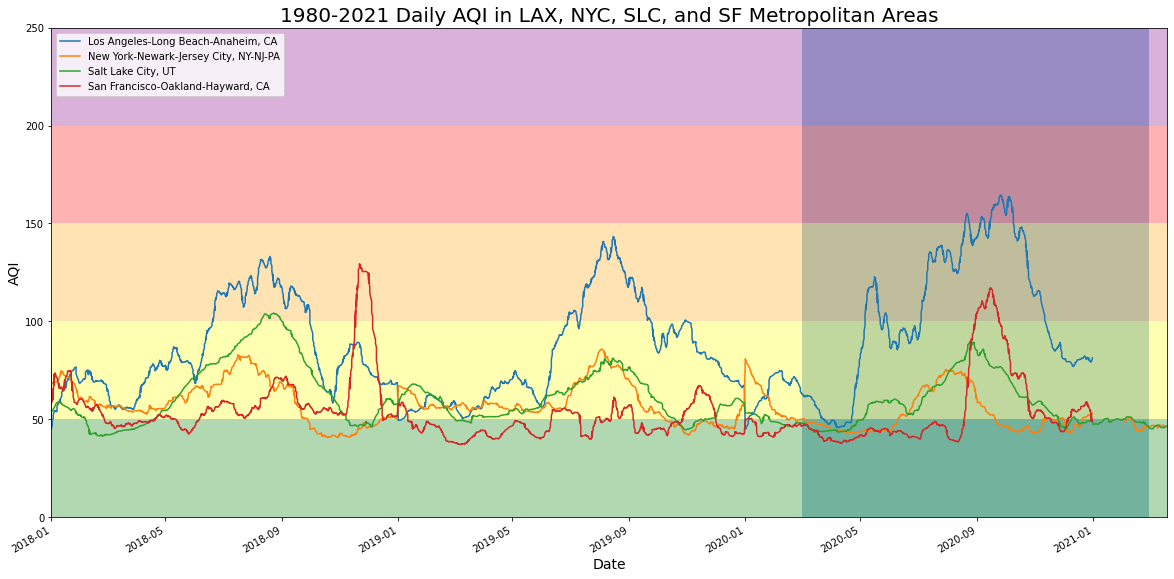

In [81]:
# figure set up
fig, ax = plt.subplots(figsize=(20, 10))

# add data
cbsa_rolling.groupby('CBSA')['rolling_AQI_mean'].plot(ax=ax,legend='False')
#cbsa_rolling.groupby('CBSA')['AQI'].plot(ax=ax,legend='False')

# 
plt.title('1980-2021 Daily AQI in LAX, NYC, SLC, and SF Metropolitan Areas', fontsize=20)
plt.xlabel('Date', fontsize=14)
plt.ylabel('AQI', fontsize=14)
plt.xlim([np.datetime64('2018-01-01'), np.datetime64('2021-03-20')])
plt.ylim(0,250)
plt.axvspan(np.datetime64('2020-03-01'), np.datetime64('2021-03-01'), alpha=0.4)

ax.axhspan(0, 50, facecolor='green', alpha=0.3)
ax.axhspan(50, 100, facecolor='yellow', alpha=0.3)
ax.axhspan(100, 150, facecolor='orange', alpha=0.3)
ax.axhspan(150, 200, facecolor='red', alpha=0.3)
ax.axhspan(200, 300, facecolor='purple', alpha=0.3)
ax.axhspan(300, 600, facecolor='maroon', alpha=0.3)

### Create geodataframe 

In [60]:
# convert to geodataframe
geoms=gpd.points_from_xy(cbsa_df['Longitude'], cbsa_df['Latitude'], crs='EPSG:4326')

cbsa_gdf=gpd.GeoDataFrame(cbsa_df,geometry=geoms)

### Subset AQI datasets

In [61]:
lax = cbsa_gdf[cbsa_gdf['CBSA'].str.contains("Los Angeles")]
sf = cbsa_gdf[cbsa_gdf['CBSA'].str.contains("San Francisco")]
slc = cbsa_gdf[cbsa_gdf['CBSA'].str.contains("Salt Lake")]
nyc = cbsa_gdf[cbsa_gdf['CBSA'].str.contains("New York")]

In [62]:
lax.dtypes

AQI                      int64
Defining Parameter      object
Category              category
CBSA                    object
Longitude              float64
Latitude               float64
geometry              geometry
dtype: object

### Location of Monitoring Stations

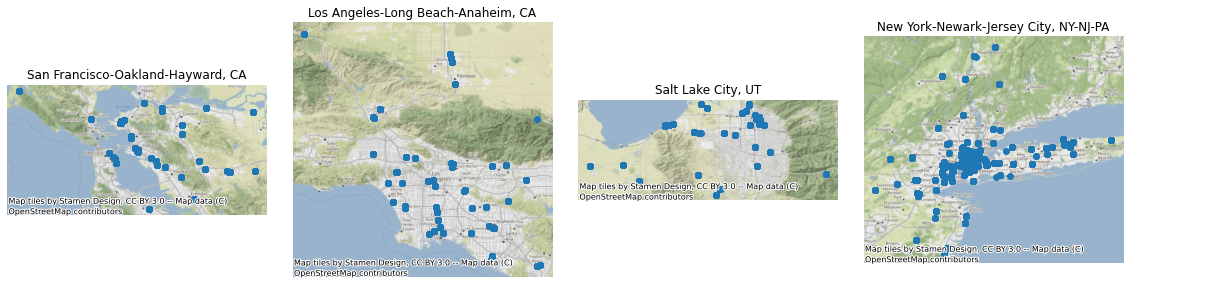

In [82]:
fig,(ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize=(20,20))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

ax1.set_title('San Francisco-Oakland-Hayward, CA')
ax2.set_title('Los Angeles-Long Beach-Anaheim, CA')
ax3.set_title('Salt Lake City, UT')
ax4.set_title('New York-Newark-Jersey City, NY-NJ-PA')

sf['geometry'].plot(ax=ax1)
lax['geometry'].plot(ax=ax2)
slc['geometry'].plot(ax=ax3)
nyc['geometry'].plot(ax=ax4)

cx.add_basemap(ax1, crs=4326)
cx.add_basemap(ax2, crs=4326)
cx.add_basemap(ax3, crs=4326)
cx.add_basemap(ax4, crs=4326)

for ax in (ax1,ax2,ax3,ax4):
    ax.axis('off')